In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [2]:
coca=pd.read_excel("CocaCola_Sales_Rawdata.xlsx", sheet_name='Sheet1')
coca.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
coca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [4]:
coca.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [5]:
coca.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [6]:
# We will extract Quarter values and Year values separately from 'Quarter column'
coca['Quarters']=0
coca['Year']=0
for i in range(42):
    p=coca["Quarter"][i]
    coca['Quarters'][i]=p[0:2]
    coca['Year'][i]=p[3:5]

In [7]:
coca.head()

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [8]:
# Getting dummy variables for Q1,Q2,Q3,Q4
quarters_dummies = pd.DataFrame(pd.get_dummies(coca['Quarters']))
coca = pd.concat([coca,quarters_dummies],axis=1)
coca.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [9]:
coca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quarter   42 non-null     object 
 1   Sales     42 non-null     float64
 2   Quarters  42 non-null     object 
 3   Year      42 non-null     object 
 4   Q1        42 non-null     uint8  
 5   Q2        42 non-null     uint8  
 6   Q3        42 non-null     uint8  
 7   Q4        42 non-null     uint8  
dtypes: float64(1), object(3), uint8(4)
memory usage: 1.6+ KB


<AxesSubplot: xlabel='Quarters', ylabel='Year'>

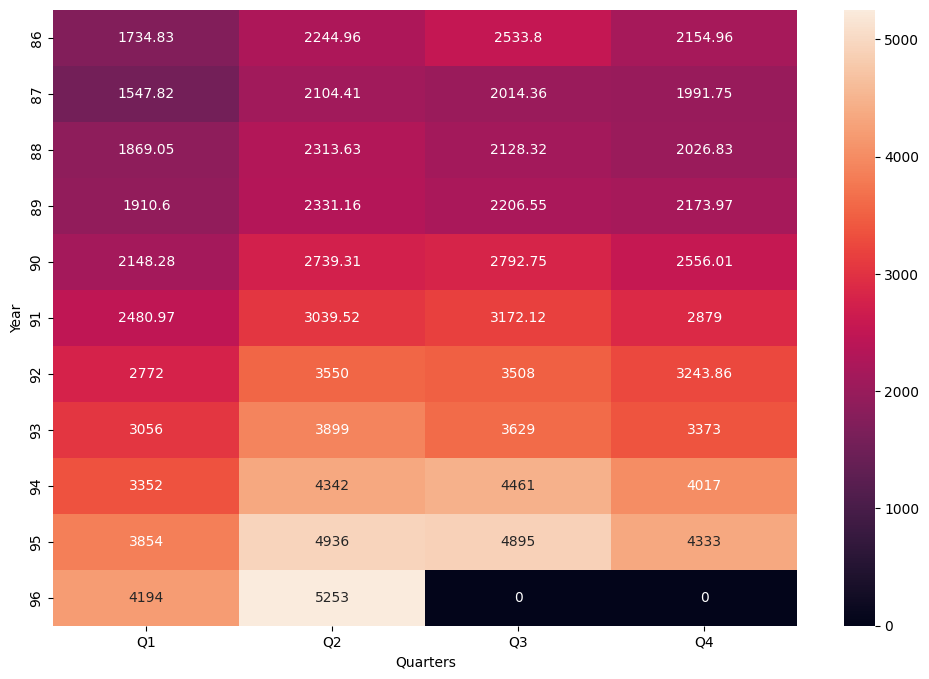

In [10]:
# Heatmap
plt.figure(figsize=(12,8))
heatmap_y_year = pd.pivot_table(data=coca,values="Sales",index="Year",columns="Quarters",fill_value=0)
sns.heatmap(heatmap_y_year,annot=True,fmt="g")

<AxesSubplot: >

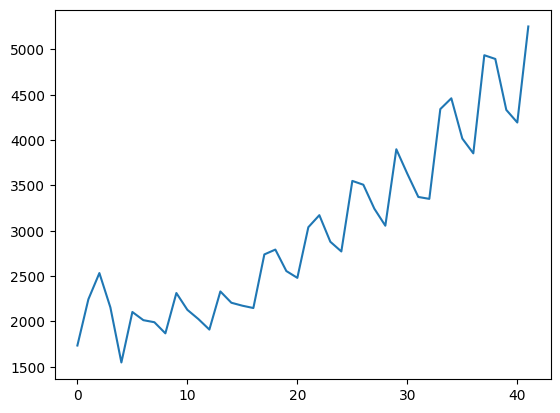

In [11]:
# Lineplot
coca.Sales.plot()

<AxesSubplot: >

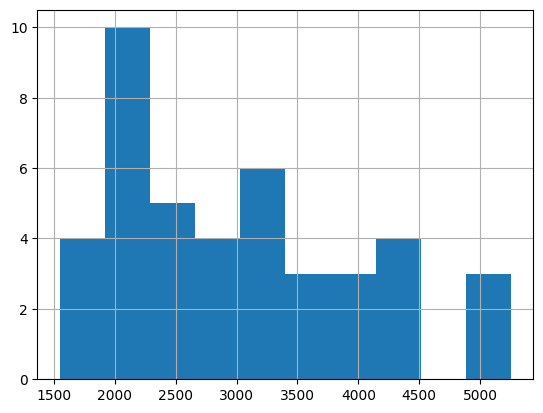

In [12]:
# Histogram
coca.Sales.hist()

<AxesSubplot: ylabel='Density'>

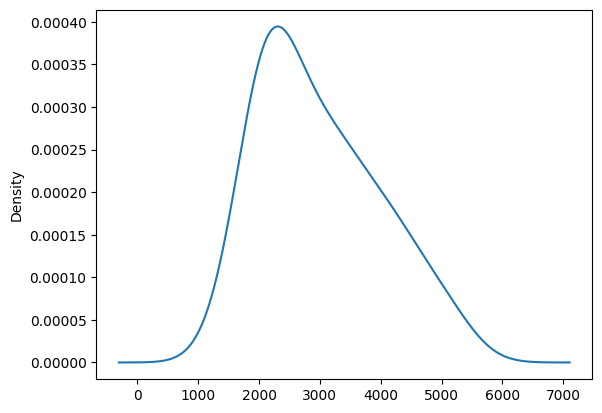

In [13]:
# Density Plot
coca.Sales.plot(kind='kde')

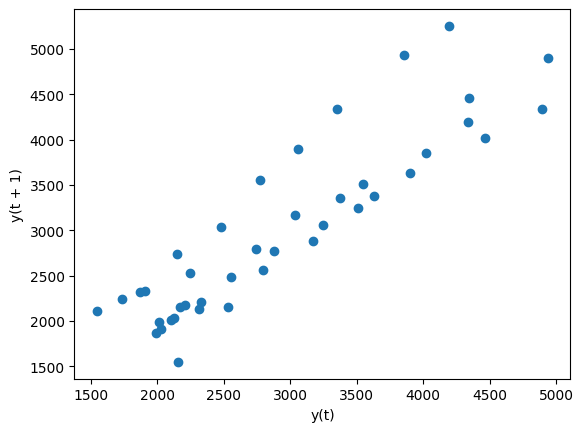

In [14]:
# Lag Plot
lag_plot(coca.Sales)
plt.show()

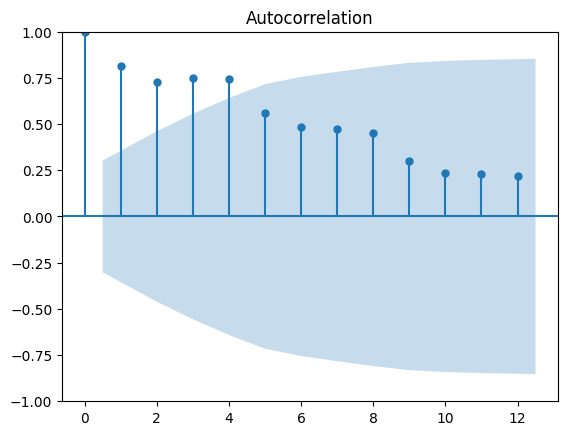

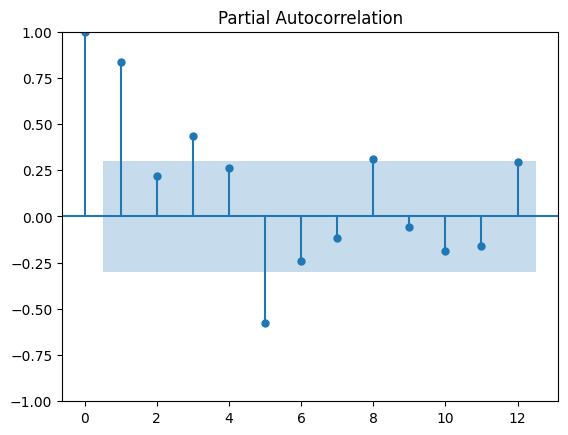

In [15]:
# ACF and PACF Plot
tsa_plots.plot_acf(coca.Sales,lags=12)
tsa_plots.plot_pacf(coca.Sales,lags=12)
plt.show()

<AxesSubplot: xlabel='Year', ylabel='Sales'>

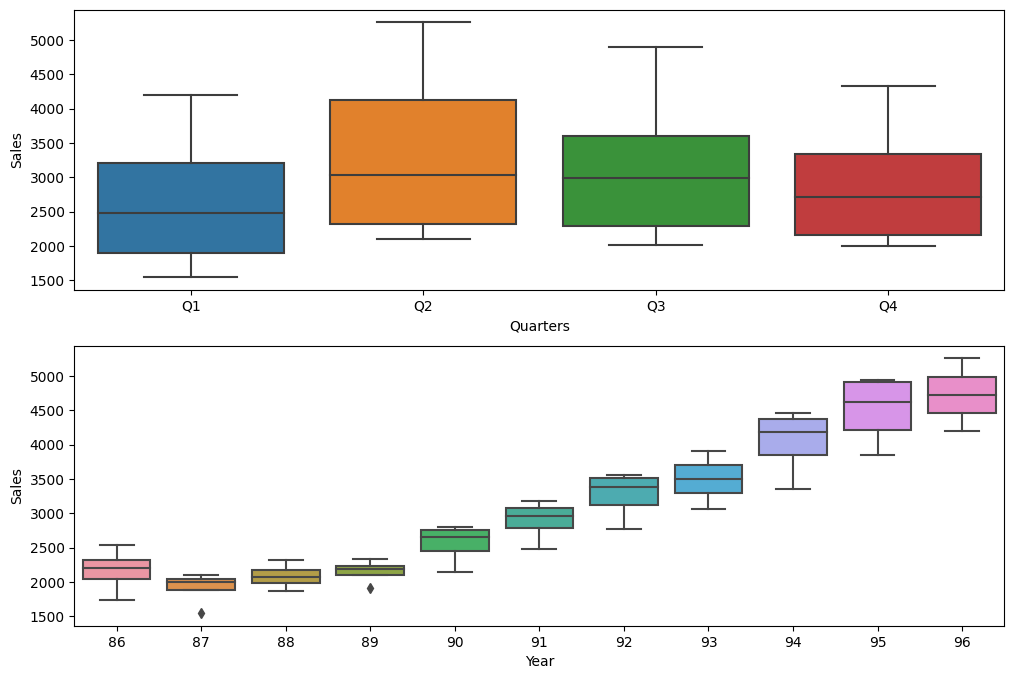

In [16]:
# Boxplot
plt.figure(figsize=(12,8))
plt.subplot(211)
sns.boxplot(x="Quarters",y="Sales",data=coca)
plt.subplot(212)
sns.boxplot(x="Year",y="Sales",data=coca)

In [17]:
#Data Preprocessing for Models
coca["t"] = np.arange(1,43)
coca["t_squared"] = coca["t"]*coca["t"]
coca["log_sales"] = np.log(coca["Sales"])
coca.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


<AxesSubplot: xlabel='Year', ylabel='Sales'>

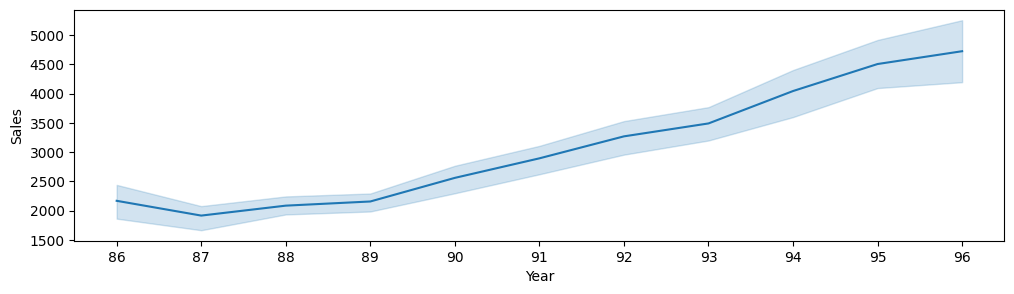

In [18]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Year",y="Sales",data=coca)

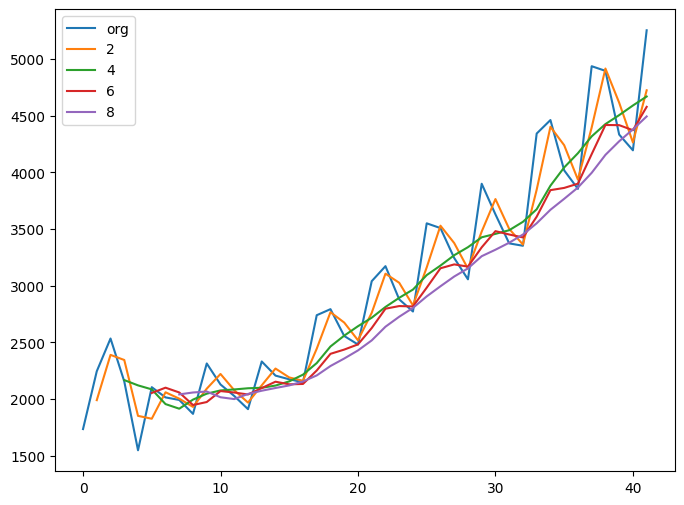

In [19]:
# Moving Average
plt.figure(figsize=(8,6))
coca.Sales.plot(label="org")
for i in range(2,10,2):
    coca["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

<AxesSubplot: >

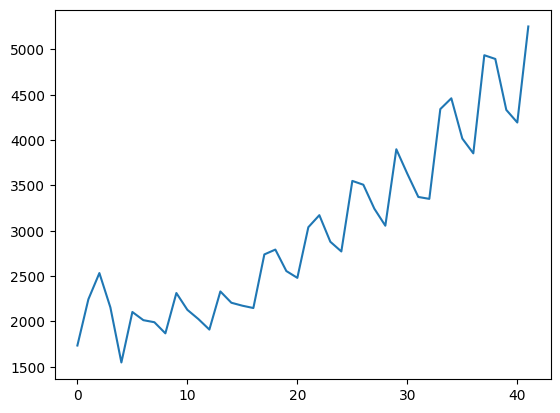

In [20]:
coca.Sales.plot()

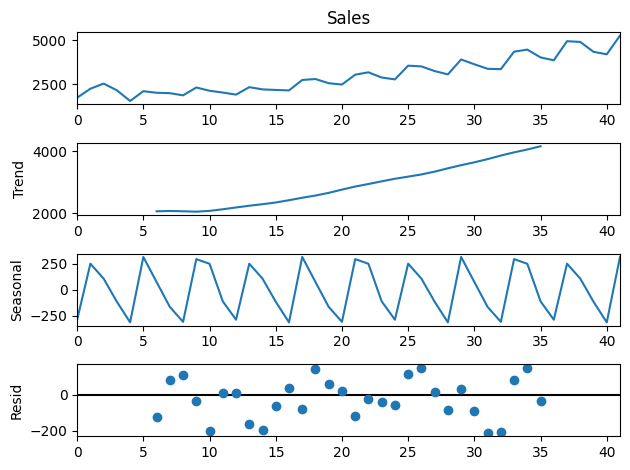

In [21]:
# Time coca Decomposition Plot
decompose_ts_add = seasonal_decompose(coca.Sales,period=12)
decompose_ts_add.plot()
plt.show()

In [22]:
# Splitting data
train = coca.head(32)
test = coca.tail(10)

In [23]:
# Linear Model
linear_model = smf.ols('Sales~t', data=train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_linear))**2))
rmse_linear

752.9233932767132

In [24]:
# Exponential Model
Exp = smf.ols('log_sales~t', data=train).fit()
pred_exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

590.3316432076668

In [25]:
# Quadratic 
Quad = smf.ols('Sales~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

457.7357355407403

In [26]:
# Additive seasonality 
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1850.466546185836

In [27]:
# Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

277.35107711286804

In [28]:
# Multiplicative Seasonality
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1908.2503948361164

In [31]:
# Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

448.8678182691278

In [32]:
# Compare the results 
data = {"MODEL":pd.Series(["rmse_linear","rmse_exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series(['rmse_linear','rmse_exp','rmse_Quad','rmse_add_sea','rmse_add_sea_quad','rmse_Mult_sea','rmse_Mult_add_sea'])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,rmse_Mult_add_sea
5,rmse_Mult_sea,rmse_Mult_sea
2,rmse_quad,rmse_Quad
3,rmse_add_sea,rmse_add_sea
4,rmse_add_sea_quad,rmse_add_sea_quad
1,rmse_exp,rmse_exp
0,rmse_linear,rmse_linear


In [33]:
data = [['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'],['Q2_97', 'Q2']]
print(data)
forecast = pd.DataFrame(data, columns = ['Quarter', 'quarter'])
forecast

[['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'], ['Q2_97', 'Q2']]


,Quarter,quarter
0,Q3_96,Q3
1,Q4_96,Q4
2,Q1_97,Q1
3,Q2_97,Q2


In [34]:
# Create dummies and T and T-Squared columns
dummies = pd.DataFrame(pd.get_dummies(forecast['quarter']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,5)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter Dummy, T and T-Square\n\n",forecast1.head())


After Dummy, T and T-Square

   Quarter quarter  Q1  Q2  Q3  Q4  t  t_squared
0   Q3_96      Q3   0   0   1   0  1          1
1   Q4_96      Q4   0   0   0   1  2          4
2   Q1_97      Q1   1   0   0   0  3          9
3   Q2_97      Q2   0   1   0   0  4         16


In [37]:
# Forecasting using Additive Seasonality Quadratic Model
model_full = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=coca).fit()
pred_new  = pd.Series(model_full.predict(forecast1))
pred_new

forecast1["forecasted_sales"] = pd.Series(pred_new)

In [38]:
# Final Prediction for next 4 Quarters
Final_predict = forecast1.loc[:, ['Quarter', 'forecasted_sales']] 
Final_predict

,Quarter,forecasted_sales
0,Q3_96,2180.858824
1,Q4_96,1851.383709
2,Q1_97,1635.419724
3,Q2_97,2284.261547
